Autor koda: Šimun Šopar (osim funkcije reset_parameters klase ConvolutionalModel i funkcije draw_filters, to je autor FER)

In [36]:
import layers

In [6]:
import torch
from torch import nn
import numpy as np
from torch.optim import SGD
from pathlib import Path
from parse import parse 
import matplotlib.pyplot as plt

import skimage as ski
import skimage.io

from IPython.display import clear_output

from torch.utils.data import DataLoader, TensorDataset

from torchvision.datasets import MNIST

In [12]:
pool1 = nn.MaxPool1d(kernel_size = 3, stride = 3)

t = torch.Tensor([[1,2,3,4,5,2, 70]])
pool1(t)

tensor([[3., 5.]])

In [4]:
class ConvolutionalModel(nn.Module):
    def __init__(self, pic_size, in_channels, conv1_width, pool1_size, conv2_width, pool2_size, fc1_width, class_count):
        super().__init__()
        
        self.pic_size = pic_size #size of current layer
        self.regulizers = []
        
        self.conv1_width = conv1_width
        
        self.conv1 = nn.Conv2d(in_channels, conv1_width, kernel_size=5, stride=1, padding=2, bias=True)
        self.pool1 = nn.MaxPool2d(kernel_size = pool1_size, stride = pool1_size)
        self.relu1 = nn.ReLU() #možda treba zamijeniti relu i pool
        
        self.regulizers.append(self.conv1.weight)
        
        for i in range(len(self.pic_size)):
            if(len(np.shape(pool1_size)) == 0):
                p_size = pool1_size
            else:
                p_size = pool1_size[i]
                
            self.pic_size[i] = np.floor(self.pic_size[i]/p_size)
            
        
        self.conv2 = nn.Conv2d(conv1_width, conv2_width, kernel_size=5, stride=1, padding=2, bias=True)
        self.pool2 = nn.MaxPool2d(kernel_size = pool2_size, stride = pool2_size)
        self.relu2 = nn.ReLU()
        
        self.regulizers.append(self.conv2.weight)
        #self.flat = nn.Flatten()
    
        for i in range(len(self.pic_size)):
            if(len(np.shape(pool2_size)) == 0):
                p_size = pool2_size
            else:
                p_size = pool2_size[i]
                
            self.pic_size[i] = np.floor(self.pic_size[i]/p_size)
    
        # potpuno povezani slojevi
        self.fc1 = nn.Linear((int)(conv2_width * self.pic_size[0] * self.pic_size[1]), fc1_width, bias=True)
        self.fc_logits = nn.Linear(fc1_width, class_count, bias=True)
        
        self.regulizers.append(self.fc1.weight)

        # parametri su već inicijalizirani pozivima Conv2d i Linear
        # ali možemo ih drugačije inicijalizirati
        self.reset_parameters()

    #@author FER
    def reset_parameters(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear) and m is not self.fc_logits:
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                nn.init.constant_(m.bias, 0)
        self.fc_logits.reset_parameters()

    def forward(self, x):
        h = self.conv1(x)
        h = self.pool1(h)
        h = self.relu1(h)
        
        h = self.conv2(h)
        h = self.pool2(h)
        h = self.relu2(h)
        
        
        h = h.view(h.shape[0], -1)
        h = self.fc1(h)
        h = torch.relu(h)
        logits = self.fc_logits(h)
        
         
        return logits
    
    def get_regulizers(self):
        flat = nn.Flatten(start_dim = 0)
        tmp = torch.Tensor()
        for i in range(len(self.regulizers)):
            for j in range(len(self.regulizers[i])):
                tmp = torch.cat((tmp, flat(self.regulizers[i][j])))
        return tmp
        
    

def loss_fun(model, y_, logits, decay = 1e-4):
    lsoft = nn.LogSoftmax(dim = 1)
    y = lsoft(logits)
    w = model.get_regulizers()
    return -(y_ * y).mean() + decay * torch.sum(w**2)


def train(model, x, y_, optimizer):
    logits = model.forward(x)
    loss = loss_fun(model, y_, logits)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
#@author FER  
def draw_filters(model, epoch = 0):
    C = model.conv1_width
    weights = model.conv1.weight.clone()
    draw = []
    for i, w in enumerate(weights):
        tmp_w = w[0].detach().numpy()
        tmp_w -= np.min(tmp_w)
        tmp_w /= np.max(tmp_w)
        draw.append(tmp_w)
        if(i != len(weights) - 1):
            draw.append(np.array([[0, 0, 0] for k in range(len(tmp_w))]))
    
    draw = np.concatenate(draw, axis = 1)
    filename = 'out/zad3/epoch = ' + str(epoch) + '.png'
    ski.io.imsave(filename, draw)

In [5]:
#data and model initializer

#DATA_DIR = Path(__file__).parent / 'MNIST data'
DATA_DIR = 'MNIST data'

ds_train, ds_test = MNIST(DATA_DIR, train=True, download=False), MNIST(DATA_DIR, train=False)
train_x = ds_train.data.reshape([-1, 1, 28, 28]).numpy().astype(float) / 255
train_y = ds_train.targets.numpy()
train_x, valid_x = train_x[:55000], train_x[55000:]
train_y, valid_y = train_y[:55000], train_y[55000:]
test_x = ds_test.data.reshape([-1, 1, 28, 28]).numpy().astype(float) / 255
test_y = ds_test.targets.numpy()
train_mean = train_x.mean()
train_x, valid_x, test_x = (torch.Tensor(x - train_mean) for x in (train_x, valid_x, test_x))
train_y, valid_y, test_y = (nn.functional.one_hot(torch.Tensor(y).to(torch.int64), 10) for y in (train_y, valid_y, test_y))

dataset_train = TensorDataset(train_x, train_y)
#dataset_test = TensorDataset(test_x, test_y)
#dataset_valid = TensorDataset(valid_x, valid_y)


model = ConvolutionalModel([28, 28], 1, 16, 5, 32, 5, 512, 10)
optimizer = SGD(model.parameters(), lr = 1e-2)

epoch_num = 8
batch_size = 100

error_log = 'out/zad3/log.txt'
error_file = open(error_log, 'w')

logits = model.forward(valid_x)
val_error = loss_fun(model, valid_y, logits)

draw_filters(model)
error_file.write('Epoch = 0: Error = ' + str((float)(val_error)) + '\n')

clear_output()

In [6]:
#learning

for epoch in range(1, epoch_num + 1):
    print('Epoch:', epoch)
    loader = DataLoader(dataset_train, batch_size)
    loader = list(loader)
    
    for i, batch in enumerate(loader):
        len_batch = len(loader)
        if(i % 10 == 0):
            print('Batch progress:', i/len_batch*100, '%')
        train(model, batch[0], batch[1], optimizer)
        
    logits = model.forward(valid_x)
    val_error = loss_fun(model, valid_y, logits)
    error_file.write('Epoch = ' + str(epoch) + ': Error = ' + str((float)(val_error)) + '\n')
    
    draw_filters(model, epoch)
    clear_output()
    
error_file.close()

In [7]:
torch.save(model.state_dict(), 'out/zad3/model-2-4-23.pth')

In [2]:
error_log = 'out/zad3/log.txt'

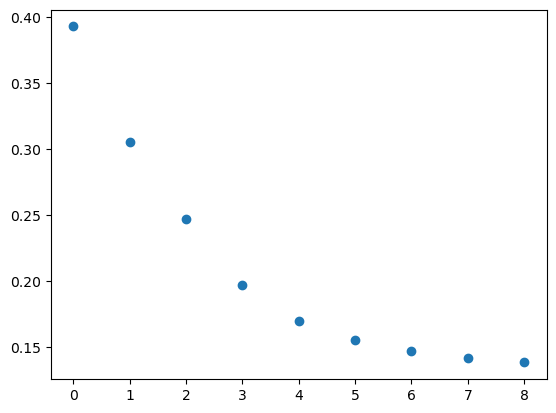

In [8]:
#plotting
error_file = open(error_log, 'r')

epoch_mesh = []
err_mesh = []

for line in error_file.readlines():
    epoch, error = parse('Epoch = {}: Error = {}', line)
    epoch_mesh.append((int)(epoch))
    err_mesh.append((float)(error))


error_file.close()

plt.scatter(epoch_mesh, err_mesh)